In [110]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import pickle
from tqdm import tqdm
import time

# CONFIGURE

In [88]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)

In [3]:
DATA_PATH = '../data/raw_data/phase-2/prob-1'

In [4]:
DATA_FILE = 'raw_train.parquet'

# PREPARE DATA

In [5]:
df_train = pd.read_parquet(f'{DATA_PATH}/{DATA_FILE}', engine='fastparquet')
df_train.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,label
0,0.041847,tcp,-,FIN,38.0,40.0,2438.0,19266.0,31.0,29.0,4.538438e+05,3.591177e+06,7.0,13.0,1.153722,1.058410,68.764188,66.421092,255.0,3.898436e+09,1.827204e+09,255.0,0.000707,0.000566,0.000141,64.0,482.0,0.0,0.0,6.0,0.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,11.0,0.0,0
1,1.089133,tcp,http,FIN,14.0,18.0,1684.0,10168.0,31.0,29.0,1.148804e+04,7.054418e+04,3.0,5.0,83.751772,64.035706,9346.434820,8182.385202,255.0,3.051186e+09,9.067852e+08,255.0,0.000665,0.000523,0.000142,120.0,565.0,1.0,3924.0,1.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0
2,0.000002,udp,dns,INT,2.0,0.0,114.0,0.0,254.0,0.0,2.280000e+08,0.000000e+00,0.0,0.0,0.002000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,57.0,0.0,0.0,0.0,25.0,2.0,18.0,17.0,17.0,25.0,0.0,0.0,0.0,17.0,25.0,0.0,1
3,1.467246,tcp,ftp,FIN,12.0,12.0,2618.0,682.0,254.0,252.0,1.308574e+04,3.413197e+03,3.0,4.0,133.386003,124.152453,7744.976658,198.329344,255.0,2.477915e+09,1.653923e+09,255.0,0.173821,0.101319,0.072502,218.0,57.0,0.0,0.0,3.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,2.0,3.0,0.0,1
4,0.000927,udp,dns,CON,2.0,2.0,130.0,162.0,31.0,29.0,5.609493e+05,6.990291e+05,0.0,0.0,0.002000,0.003000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,65.0,81.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,4.0,0.0,0


In [6]:
print('Missing values in train data:', df_train.isnull().sum().sum())

Missing values in train data: 0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61841 entries, 0 to 61840
Data columns (total 42 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   61841 non-null  float64
 1   feature2   61841 non-null  object 
 2   feature3   61841 non-null  object 
 3   feature4   61841 non-null  object 
 4   feature5   61841 non-null  float64
 5   feature6   61841 non-null  float64
 6   feature7   61841 non-null  float64
 7   feature8   61841 non-null  float64
 8   feature9   61841 non-null  float64
 9   feature10  61841 non-null  float64
 10  feature11  61841 non-null  float64
 11  feature12  61841 non-null  float64
 12  feature13  61841 non-null  float64
 13  feature14  61841 non-null  float64
 14  feature15  61841 non-null  float64
 15  feature16  61841 non-null  float64
 16  feature17  61841 non-null  float64
 17  feature18  61841 non-null  float64
 18  feature19  61841 non-null  float64
 19  feature20  61841 non-null  float64
 20  featur

# Explore

In [91]:
print(df_train.groupby('label')['feature4'].value_counts())

label  feature4
0      FIN         14761
       CON          4520
       INT          2455
       REQ           634
       RST            16
       ECO             3
       ACC             1
1      INT         25427
       FIN         13404
       CON           328
       REQ           288
       RST             4
Name: feature4, dtype: int64


# TRAIN TEST SPLIT

In [8]:
X = df_train.copy()
y = X.pop('label')

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y,
                                                  test_size=0.2, random_state=42)

# Baseline model

In [18]:
kf = KFold(n_splits=5)
oof_preds = pd.Series(index=X_train.index, dtype='float64')

for n_fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_train_kf, X_oof_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_oof_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    # Select only numerical features
    X_train_kf = X_train_kf.select_dtypes(include='number')
    X_oof_kf = X_oof_kf.select_dtypes(include='number')

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_kf, y_train_kf)

    oof_preds.iloc[test_index] = model.predict(X_oof_kf)

print('Baseline score:', roc_auc_score(y_train, oof_preds))

Baseline score: 0.7455900300638921


In [24]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train.select_dtypes(include='number'), y_train)

t1 = time.time()
y_pred = model.predict(X_val.select_dtypes(include='number'))
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.003992319107055664
Validation score: 0.7431797686307562


# Standard Scale

In [15]:
scaler = StandardScaler()

In [25]:
kf = KFold(n_splits=5)
oof_preds = pd.Series(index=X_train.index, dtype='float64')

for n_fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_train_kf, X_oof_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_oof_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    # Select only numerical features
    X_train_kf = X_train_kf.select_dtypes(include='number')
    X_oof_kf = X_oof_kf.select_dtypes(include='number')

    X_train_kf = scaler.fit_transform(X_train_kf)
    X_oof_kf = scaler.transform(X_oof_kf)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_kf, y_train_kf)

    oof_preds.iloc[test_index] = model.predict(X_oof_kf)

print('Baseline score:', roc_auc_score(y_train, oof_preds))

Baseline score: 0.8601681732576839


In [26]:
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include='number'))
X_val_scaled = scaler.transform(X_val.select_dtypes(include='number'))

model = LogisticRegression(max_iter=1000)


model.fit(X_train_scaled, y_train)
t1 = time.time()
y_pred = model.predict(X_val_scaled)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.001981019973754883
Validation score: 0.8541726320355577


# Ordinal Encode

In [27]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

In [11]:
categorical_columns = ["feature2", "feature3", "feature4"]
numerical_columns = ["feature1", "feature5", "feature6", "feature7", "feature8", "feature9",
                    "feature10", "feature11", "feature12", "feature13", "feature14", "feature15",
                    "feature16", "feature17", "feature18", "feature19", "feature20", "feature21",
                    "feature22", "feature23", "feature24", "feature25", "feature26", "feature27",
                    "feature28", "feature29", "feature30", "feature31", "feature32", "feature33",
                    "feature34", "feature35", "feature36", "feature37", "feature38", "feature39",
                    "feature40", "feature41"]

In [29]:
kf = KFold(n_splits=5)
oof_preds = pd.Series(index=X_train.index, dtype='float64')

for n_fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_train_kf, X_oof_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_oof_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_cat_kf = encoder.fit_transform(X_train_kf[categorical_columns])
    X_oof_cat_kf = encoder.transform(X_oof_kf[categorical_columns])

    X_train_kf = scaler.fit_transform(np.concatenate([X_train_kf[numerical_columns], X_train_cat_kf], axis=1))
    X_oof_kf = scaler.transform(np.concatenate([X_oof_kf[numerical_columns], X_oof_cat_kf], axis=1))

    model = LogisticRegression(max_iter=10000)
    model.fit(X_train_kf, y_train_kf)

    oof_preds.iloc[test_index] = model.predict(X_oof_kf)

print('Baseline score:', roc_auc_score(y_train, oof_preds))

Baseline score: 0.8708985302600348


In [30]:
X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_val_cat = encoder.transform(X_val[categorical_columns])

X_train_solution_3 = scaler.fit_transform(np.concatenate([X_train[numerical_columns], X_train_cat], axis=1))
X_val_solution_3 = scaler.transform(np.concatenate([X_val[numerical_columns], X_val_cat], axis=1))

model = LogisticRegression(max_iter=1000)
model.fit(X_train_solution_3, y_train)
t1 = time.time()
y_pred = model.predict(X_val_solution_3)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.0009965896606445312
Validation score: 0.8641553131039714


# Onehot encode

In [31]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

In [32]:
kf = KFold(n_splits=5)
oof_preds = pd.Series(index=X_train.index, dtype='float64')

for n_fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_train_kf, X_oof_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_oof_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_cat_kf = encoder.fit_transform(X_train_kf[categorical_columns])
    X_oof_cat_kf = encoder.transform(X_oof_kf[categorical_columns])

    X_train_kf = scaler.fit_transform(np.concatenate([X_train_kf[numerical_columns], X_train_cat_kf], axis=1))
    X_oof_kf = scaler.transform(np.concatenate([X_oof_kf[numerical_columns], X_oof_cat_kf], axis=1))

    model = LogisticRegression(max_iter=10000)
    model.fit(X_train_kf, y_train_kf)

    oof_preds.iloc[test_index] = model.predict(X_oof_kf)

print('Baseline score:', roc_auc_score(y_train, oof_preds))

Baseline score: 0.8777910780263007


In [33]:
X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_val_cat = encoder.transform(X_val[categorical_columns])

X_train_solution_3 = scaler.fit_transform(np.concatenate([X_train[numerical_columns], X_train_cat], axis=1))
X_val_solution_3 = scaler.transform(np.concatenate([X_val[numerical_columns], X_val_cat], axis=1))

model = LogisticRegression(max_iter=1000)
model.fit(X_train_solution_3, y_train)

t1 = time.time()
y_pred = model.predict(X_val_solution_3)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.005040645599365234
Validation score: 0.8703717958434225


# Bla

In [107]:
categorical_columns = ["feature2", "feature3", "feature4"]
numerical_columns = ["feature1", "feature5", "feature6", "feature7", "feature8", "feature9",
                    "feature10", "feature11", "feature12", "feature13", "feature14", "feature15",
                    "feature16", "feature17", "feature18", "feature19", "feature20", "feature21",
                    "feature22", "feature23", "feature24", "feature25", "feature26", "feature27",
                    "feature28", "feature29", "feature30", "feature31", "feature32", "feature33",
                    "feature34", "feature35", "feature36", "feature37", "feature38", "feature39",
                    "feature40", "feature41"]

In [108]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

In [16]:
models = {
    'linear model': LogisticRegression(max_iter=10000),
    'random forest': RandomForestClassifier(random_state=42),
    'xgboost': XGBClassifier(random_state=42),
    'catboost': CatBoostClassifier(random_state=42, verbose=0),
    'lightgbm': LGBMClassifier(random_state=42),
}

In [20]:
for model_name in models:
    print(f'Fitting {model_name}...')
    kf = KFold(n_splits=5)
    oof_preds = pd.Series(index=X_train.index, dtype='float64')
    for train_index, test_index in tqdm(kf.split(X_train, y_train), total=kf.get_n_splits()):
        X_train_kf, X_oof_kf = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_kf, y_oof_kf = y_train.iloc[train_index], y_train.iloc[test_index]

        X_train_cat_kf = encoder.fit_transform(X_train_kf[categorical_columns])
        X_oof_cat_kf = encoder.transform(X_oof_kf[categorical_columns])

        X_train_kf = scaler.fit_transform(np.concatenate([X_train_kf[numerical_columns], X_train_cat_kf], axis=1))
        X_oof_kf = scaler.transform(np.concatenate([X_oof_kf[numerical_columns], X_oof_cat_kf], axis=1))

        model = models[model_name]
        model.fit(X_train_kf, y_train_kf)

        oof_preds.iloc[test_index] = model.predict(X_oof_kf)
    
    print(f'Score for {model_name}:', roc_auc_score(y_train, oof_preds))

Fitting linear model...


100%|██████████| 5/5 [00:26<00:00,  5.22s/it]


Score for linear model: 0.8777910780263007
Fitting random forest...


100%|██████████| 5/5 [00:51<00:00, 10.33s/it]


Score for random forest: 0.9346208700357924
Fitting xgboost...


100%|██████████| 5/5 [00:20<00:00,  4.07s/it]


Score for xgboost: 0.9368042665706614
Fitting catboost...


100%|██████████| 5/5 [01:55<00:00, 23.16s/it]


Score for catboost: 0.9378446224352149
Fitting lightgbm...


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]

Score for lightgbm: 0.9387152922243147


In [68]:
X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_val_cat = encoder.transform(X_val[categorical_columns])

X_train_num = scaler.fit_transform(X_train[numerical_columns])
X_val_num = scaler.transform(X_val[numerical_columns])

X_train_solution_3 = np.concatenate([X_train_num, X_train_cat], axis=1)
X_val_solution_3 = np.concatenate([X_val_num, X_val_cat], axis=1)

model = LGBMClassifier(random_state=42)
model.fit(X_train_solution_3, y_train)

t1 = time.time()
y_pred = model.predict(X_val_solution_3)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.011000394821166992
Validation score: 0.9344855619630779


In [24]:
X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_val_cat = encoder.transform(X_val[categorical_columns])

X_train_num = scaler.fit_transform(X_train[numerical_columns])
X_val_num = scaler.transform(X_val[numerical_columns])

X_train_solution_3 = np.concatenate([X_train_num, X_train_cat], axis=1)
X_val_solution_3 = np.concatenate([X_val_num, X_val_cat], axis=1)

model = XGBClassifier(random_state=42)
model.fit(X_train_solution_3, y_train)

t1 = time.time()
y_pred = model.predict(X_val_solution_3)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.013005256652832031
Validation score: 0.9338303359376915


# BLA LA LA

In [94]:
X_train['feature3'].value_counts()

-           27194
dns         13113
http         5216
smtp         1356
ftp-data     1015
ftp           918
pop3          301
ssh           277
dhcp           32
ssl            22
snmp           17
irc             7
radius          4
Name: feature3, dtype: int64

# Tuning

In [112]:
params = {'learning_rate': 0.0896699585809208, 'n_estimators': 6174, 'max_depth': 12, 'num_leaves': 397, 'tree_learner': 'serial', 'min_child_samples': 22, 'min_child_weight': 0.11941736917167599, 'subsample': 0.39882930631767044, 'pos_bagging_fraction': 0.623668964456346, 'neg_bagging_fraction': 0.9904104607995861, 'subsample_freq': 19, 'colsample_bytree': 0.48831301443739894, 'feature_fraction_bynode': 0.8839962199300008, 'extra_trees': False, 'reg_alpha': 0.11239683811060446, 'linear_lambda': 0.7000671833692591, 'max_delta_step': 5, 'min_split_gain': 2}

In [114]:
kf = KFold(n_splits=5)
oof_preds = pd.Series(index=X_train.index, dtype='float64')

for train_index, test_index in tqdm(kf.split(X_train, y_train), total=kf.get_n_splits()):
    X_train_kf, X_oof_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_oof_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_cat_kf = encoder.fit_transform(X_train_kf[categorical_columns])
    X_oof_cat_kf = encoder.transform(X_oof_kf[categorical_columns])

    X_train_num_kf = scaler.fit_transform(X_train_kf[numerical_columns])
    X_oof_num_kf = scaler.transform(X_oof_kf[numerical_columns])

    X_train_kf = np.concatenate([X_train_num_kf, X_train_cat_kf], axis=1)
    X_oof_kf = np.concatenate([X_oof_num_kf, X_oof_cat_kf], axis=1)


    model = LGBMClassifier(**params, objective='binary', random_state=42, early_stopping_round=300, metric='auc')
    model.fit(X_train_kf, y_train_kf, eval_set=[(X_oof_kf, y_oof_kf)], callbacks=[lgbm.log_evaluation(0)], eval_metric='auc')

    oof_preds.iloc[test_index] = model.predict(X_oof_kf)

print('oof score:', roc_auc_score(y_train, oof_preds))

100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

oof score: 0.9435763408320413


In [116]:
X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_val_cat = encoder.transform(X_val[categorical_columns])

X_train_num = scaler.fit_transform(X_train[numerical_columns])
X_val_num = scaler.transform(X_val[numerical_columns])

X_train_solution_3 = np.concatenate([X_train_num, X_train_cat], axis=1)
X_val_solution_3 = np.concatenate([X_val_num, X_val_cat], axis=1)

model = LGBMClassifier(**params, objective='binary', random_state=42, early_stopping_round=300, metric='auc')
model.fit(X_train_solution_3, y_train, eval_set=[(X_val_solution_3, y_val)], callbacks=[lgbm.log_evaluation(0)], eval_metric='auc')

t1 = time.time()
y_pred = model.predict(X_val_solution_3)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.01099848747253418
Validation score: 0.9418107755461598


# Poly

In [11]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [12]:
kf = KFold(n_splits=5)
oof_preds = pd.Series(index=X_train.index, dtype='float64')

for train_index, test_index in tqdm(kf.split(X_train, y_train), total=kf.get_n_splits()):
    X_train_kf, X_oof_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_oof_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_cat_kf = encoder.fit_transform(X_train_kf[categorical_columns])
    X_oof_cat_kf = encoder.transform(X_oof_kf[categorical_columns])

    X_train_num_kf = scaler.fit_transform(X_train_kf[numerical_columns])
    X_oof_num_kf = scaler.transform(X_oof_kf[numerical_columns])

    X_train_num_kf = poly.fit_transform(X_train_num_kf)
    X_oof_num_kf = poly.transform(X_oof_num_kf)

    X_train_kf = np.concatenate([X_train_num_kf, X_train_cat_kf], axis=1)
    X_oof_kf = np.concatenate([X_oof_num_kf, X_oof_cat_kf], axis=1)

    # model = XGBClassifier(random_state=42, tree_method='gpu_hist')
    model = LGBMClassifier(random_state=42)
    model.fit(X_train_kf, y_train_kf)

    oof_preds.iloc[test_index] = model.predict(X_oof_kf)

print('Baseline score:', roc_auc_score(y_train, oof_preds))

100%|██████████| 5/5 [00:36<00:00,  7.32s/it]

Baseline score: 0.9394764773111298


In [13]:
X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_val_cat = encoder.transform(X_val[categorical_columns])

X_train_num = poly.fit_transform(X_train[numerical_columns])
X_val_num = poly.transform(X_val[numerical_columns])

X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)

X_train_solution_3 = np.concatenate([X_train_num, X_train_cat], axis=1)
X_val_solution_3 = np.concatenate([X_val_num, X_val_cat], axis=1)

# model = XGBClassifier(random_state=42, tree_method='gpu_hist')
model = LGBMClassifier(random_state=42)
model.fit(X_train_solution_3, y_train)

t1 = time.time()
y_pred = model.predict(X_val_solution_3)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.014995336532592773
Validation score: 0.934111197626844


# Select importance features

<BarContainer object of 190 artists>

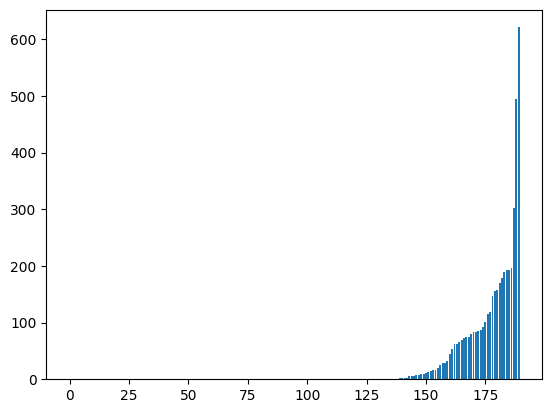

In [117]:
import matplotlib.pyplot as plt

plt.bar(range(len(model.feature_importances_)), np.sort(model.feature_importances_))

In [118]:
np.sort(model.feature_importances_)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   1,   1,   2,   2,   2,   3,
         5,   6,   6,   7,   8,   9,  10,  11,  13,  14,  16,  17,  20,
        26,  29,  29,  32,  44,  53,  62,  63,  65,  70,  72,  74,  75,
        79,  84,  84,  85,  87,  93, 101, 115, 119, 147, 155, 15

In [119]:
featurer_importances = [i for i, j in enumerate(model.feature_importances_) if j > 0]

In [97]:
for i in featurer_importances:
    print(i, end=', ')

0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 116, 134, 156, 157, 170, 171, 172, 173, 175, 179, 184, 187, 

In [120]:
kf = KFold(n_splits=5)
oof_preds = pd.Series(index=X_train.index, dtype='float64')

for train_index, test_index in tqdm(kf.split(X_train, y_train), total=kf.get_n_splits()):
    X_train_kf, X_oof_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_oof_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_cat_kf = encoder.fit_transform(X_train_kf[categorical_columns])
    X_oof_cat_kf = encoder.transform(X_oof_kf[categorical_columns])

    X_train_num_kf = scaler.fit_transform(X_train_kf[numerical_columns])
    X_oof_num_kf = scaler.transform(X_oof_kf[numerical_columns])

    # X_train_num_kf = poly.fit_transform(X_train_num_kf)
    # X_oof_num_kf = poly.transform(X_oof_num_kf)

    X_train_kf = np.concatenate([X_train_num_kf, X_train_cat_kf], axis=1)
    X_oof_kf = np.concatenate([X_oof_num_kf, X_oof_cat_kf], axis=1)

    X_train_kf = X_train_kf[:, featurer_importances]
    X_oof_kf = X_oof_kf[:, featurer_importances]

    # model = LGBMClassifier(random_state=42)
    # model.fit(X_train_kf, y_train_kf)

    model = LGBMClassifier(**params, objective='binary', random_state=42, early_stopping_round=300, metric='auc')
    model.fit(X_train_kf, y_train_kf, eval_set=[(X_oof_kf, y_oof_kf)], callbacks=[lgbm.log_evaluation(0)], eval_metric='auc')

    oof_preds.iloc[test_index] = model.predict(X_oof_kf)

print('Baseline score:', roc_auc_score(y_train, oof_preds))

100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

Baseline score: 0.9434261982677176


In [121]:
X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_val_cat = encoder.transform(X_val[categorical_columns])

# X_train_num = poly.fit_transform(X_train[numerical_columns])
# X_val_num = poly.transform(X_val[numerical_columns])

X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)

X_train_solution_3 = np.concatenate([X_train_num, X_train_cat], axis=1)
X_val_solution_3 = np.concatenate([X_val_num, X_val_cat], axis=1)

X_train_solution_3 = X_train_solution_3[:, featurer_importances]
X_val_solution_3 = X_val_solution_3[:, featurer_importances]

# model = LGBMClassifier(random_state=42)
# model.fit(X_train_solution_3, y_train)

model = LGBMClassifier(**params, objective='binary', random_state=42, early_stopping_round=300, metric='auc')
model.fit(X_train_solution_3, y_train, eval_set=[(X_val_solution_3, y_val)], callbacks=[lgbm.log_evaluation(0)], eval_metric='auc')

t1 = time.time()
y_pred = model.predict(X_val_solution_3)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.014000654220581055
Validation score: 0.9414124412516698


# SMOTEN

In [98]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [122]:
sm = SMOTE(random_state=42)
# sm = SMOTETomek(random_state=42)

In [123]:
kf = KFold(n_splits=5)
oof_preds = pd.Series(index=X_train.index, dtype='float64')

for train_index, test_index in tqdm(kf.split(X_train, y_train), total=kf.get_n_splits()):
    X_train_kf, X_oof_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_oof_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_cat_kf = encoder.fit_transform(X_train_kf[categorical_columns])
    X_oof_cat_kf = encoder.transform(X_oof_kf[categorical_columns])

    X_train_num_kf = scaler.fit_transform(X_train_kf[numerical_columns])
    X_oof_num_kf = scaler.transform(X_oof_kf[numerical_columns])

    # X_train_num_kf = poly.fit_transform(X_train_num_kf)
    # X_oof_num_kf = poly.transform(X_oof_num_kf)

    X_train_kf = np.concatenate([X_train_num_kf, X_train_cat_kf], axis=1)
    X_oof_kf = np.concatenate([X_oof_num_kf, X_oof_cat_kf], axis=1)

    # X_train_kf = X_train_kf[:, featurer_importances]
    # X_oof_kf = X_oof_kf[:, featurer_importances]

    X_train_kf, y_train_kf = sm.fit_resample(X_train_kf, y_train_kf)

    # model = LGBMClassifier(random_state=42)
    # model.fit(X_train_kf, y_train_kf)

    model = LGBMClassifier(**params, objective='binary', random_state=42, early_stopping_round=300, metric='auc')
    model.fit(X_train_kf, y_train_kf, eval_set=[(X_oof_kf, y_oof_kf)], callbacks=[lgbm.log_evaluation(0)], eval_metric='auc')

    oof_preds.iloc[test_index] = model.predict(X_oof_kf)

print('Baseline score:', roc_auc_score(y_train, oof_preds))

100%|██████████| 5/5 [00:11<00:00,  2.24s/it]

Baseline score: 0.9429464411563419


In [124]:
X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_val_cat = encoder.transform(X_val[categorical_columns])

X_train_num = scaler.fit_transform(X_train[numerical_columns])
X_val_num = scaler.transform(X_val[numerical_columns])

# X_train_num = poly.fit_transform(X_train_num)
# X_val_num = poly.transform(X_val_num)

X_train_solution_3 = np.concatenate([X_train_num, X_train_cat], axis=1)
X_val_solution_3 = np.concatenate([X_val_num, X_val_cat], axis=1)

# X_train_solution_3 = X_train_solution_3[:, featurer_importances]
# X_val_solution_3 = X_val_solution_3[:, featurer_importances]

X_res, y_res = sm.fit_resample(X_train_solution_3, y_train)

# model = LGBMClassifier(random_state=42)
# model.fit(X_res, y_res)

model = LGBMClassifier(**params, objective='binary', random_state=42, early_stopping_round=300, metric='auc')
model.fit(X_res, y_res, eval_set=[(X_val_solution_3, y_val)], callbacks=[lgbm.log_evaluation(0)], eval_metric='auc')

t1 = time.time()
y_pred = model.predict(X_val_solution_3)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))

Predict time: 0.01300358772277832
Validation score: 0.9428492662051492


# Stacking

In [39]:
from sklearn.ensemble import StackingClassifier

In [40]:
estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('cat', CatBoostClassifier(random_state=42, verbose=0)),
    ('lgbm', LGBMClassifier(random_state=42))
]

X_train_cat = encoder.fit_transform(X_train[categorical_columns])
X_val_cat = encoder.transform(X_val[categorical_columns])

X_train_num = scaler.fit_transform(X_train[numerical_columns])
X_val_num = scaler.transform(X_val[numerical_columns])

X_train_solution_3 = np.concatenate([X_train_num, X_train_cat], axis=1)
X_val_solution_3 = np.concatenate([X_val_num, X_val_cat], axis=1)

model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000))
model.fit(X_train_solution_3, y_train)

t1 = time.time()
y_pred = model.predict(X_val_solution_3)
print('Predict time:' ,time.time() - t1)

print('Validation score:', roc_auc_score(y_val, y_pred))


Predict time: 0.7475173473358154
Validation score: 0.9330394829643214


In [ ]:
model = LGBMClassifier(**params, objective='binary', random_state=42, early_stopping_round=300, metric='auc')
model.fit(X_train_kf, y_train_kf, eval_set=[(X_oof_kf, y_oof_kf)], callbacks=[lgbm.log_evaluation(0), ], verbose=0, eval_metric='auc')

# Summary
***updating...*

|   | out-of-fold score | validation score | testing score | predict Time | response Time | submitted |
|---|-------------------|------------------|---------------|--------------|---------------|-----------|
| only numerical features + logistic regression | 0.745590 | 0.743180 | 0.752868 | 0.004 | 1.40 | **true** |
| standard scale (only numerical features) + logistic regression | 0.860168 | 0.854172 | ... | 0.002 | ... | false |
| ordinal-encode + standard scale + logistic regression | 0.870898 | 0.864155 | 0.862647 | 0.0001 | 1.70 | **true** |
| onehot-encode + standard scale + logistic regression | 0.877791 | 0.870372 | ... | 0.005 | ... |false |
| onehot-encode + standard scale + XGB | 0.936804 | 0.933830 | 0.946229 | 0.009 | 1.60 | **true** |
| onehot-encode + standard scale + LGBM | 0.938715 | 0.934486 | ... | ... | ... | false |
| **onehot-encode + standard scale + LGBM (tuned)** | **0.943576** | 0.941811 | ... | ... | ... | false |
| **onehot-encode + standard scale + LGBM + SMOTE (tuned)** | 0.942946 | **0.942849** | ... | ... | ... | false |
| onehot-encode + standard scale + LGBM (importance features > 0) | 0.938958 | 0.934486 | ... | ... | ... | false |
| onehot-encode + standard scale + LGBM (importance features > 0) (tuned) | 0.943426 | 0.941412 | ... | ... | ... | false |
| onehot-encode + standard scale + LGBM (importance features > 0) + SMOTE | 0.940949 | 0.938291 | ... | 0.009 | ... | false |
| onehot-encode + standard scale + LGBM (importance features > 0) + SMOTETomek | 0.940334 | 0.936423 | ... | 0.0089 | ... | false |
| poly degree 2 + onehot-encode + standard scale + XGB | 0.935926 | 0.932204 | ... | ... | ... | false |
| poly degree 2 + onehot-encode + standard scale + LGBM | 0.939476 | 0.934111 | ... | ... | ... | false |
| poly degree 2 + onehot-encode + standard scale + LGBM (importance features > 0) | 0.939528 | 0.934111 | ... | ... | ... | false |
| poly degree 2 + onehot-encode + standard scale + LGBM (importance features > 0) + SMOTE | 0.941007 | 0.936867 | ... | ... | ... | false |
| poly degree 2 + onehot-encode + standard scale + LGBM (importance features > 0) + SMOTETomek | 0.939552 | 0.936260 | ... | ... | ... | false |


In [ ]:
0.942946
0.942849